In [1]:
import networkx as nx
import osmnx as ox
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
import geopandas as gpd

ox.__version__

'1.3.1.post0'

## Load Graph

In [2]:

location_point = (51.490938, -0.196054) #v6500
G_orig = ox.graph_from_point(location_point, dist=3250, dist_type="bbox", network_type="walk")

G_proj = ox.project_graph(G_orig)
G = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=True)

G_geo = ox.project_graph(G, to_crs='epsg:4326')
G = ox.project_graph(G, to_crs='epsg:4326')
print(G_orig)
print(G)

/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/madesant/opt/miniconda3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


MultiDiGraph with 19660 nodes and 52676 edges
MultiDiGraph with 14135 nodes and 40948 edges


## plot edges weight according to length 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

edges = ox.graph_to_gdfs(G, nodes=False)  #Load edges from G as df
edges = edges.reset_index()
display(edges.head())
edge_lengths = [G[u][v][k]['length'] for u, v, k in G.edges(keys=True)] # obtain edges weight

cmap = "viridis" #select cmap
nc = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap=cmap)
edges = ox.graph_to_gdfs(G, nodes=False)
fig, ax = plt.subplots(figsize=(8,8))
ox.plot_graph(G, edge_color=nc,node_color='none', node_edgecolor = 'none',
                        bgcolor='lightblue', edge_linewidth=1, ax = ax,
                           edge_alpha = 0.75,
                       show = False)

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(edge_lengths)

cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.03, shrink=0.8)
cbar.set_label("Edge's length [m]")
plt.xlim()
plt.tight_layout()
plt.show()
#fig.savefig('./data/ForVisualization/Length_Edges.png')


,u,v,key,osmid,ref,name,highway,maxspeed,oneway,reversed,...,v_original,geometry,lanes,service,tunnel,width,access,junction,bridge,est_width
0,0,1,0,148890705,B524,Marylebone High Street,secondary,20 mph,False,True,...,1619500464,"LINESTRING (-0.15179 51.51997, -0.15177 51.51985)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,0,4255551,NaN,Weymouth Street,tertiary,20 mph,False,False,...,1619464655,"LINESTRING (-0.15179 51.51997, -0.15167 51.519...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10547,0,74865693,NaN,Moxon Street,residential,20 mph,False,True,...,1667118119,"LINESTRING (-0.15177 51.51985, -0.15245 51.519...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,148890705,B524,Marylebone High Street,secondary,20 mph,False,False,...,101995,"LINESTRING (-0.15177 51.51985, -0.15179 51.51997)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,4,0,148890709,B524,Marylebone High Street,secondary,20 mph,False,True,...,6371330219,"LINESTRING (-0.15177 51.51985, -0.15173 51.519...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Process graph according to pollution values - preparation 

In [4]:
import pandas as pd 
nodes = ox.graph_to_gdfs(G, edges=False) # Load edges from G as df
edges = ox.graph_to_gdfs(G, nodes=False) # Load nodes from G as df
edges = edges.reset_index()

# Load nodes in tiles
nodesJava = pd.read_csv('./data/ForVisualization/nodes-in-grid.csv')

# Load pollution values from grid
gridGeom = pd.read_csv('./data/ForVisualization/g60_2023_07_20_08_00_00.csv')

nodesJava = nodesJava.merge(gridGeom, how='left', on='code') # assign node pollution value within same code from grid
nodesJava.set_index('id', inplace = True)

node = {}
edgePollution = []

# assign weights according to java logic
for index,row in edges.iterrows():
    
    try:
        #print('processed')
        u_p = nodesJava.loc[str(row["u"])+'_']["predicted_pm2.5"]
        v_p = nodesJava.loc[str(row["v"])+'_']["predicted_pm2.5"]
        valueP = (float(u_p)+float(v_p))/2  #Assign weight to edge according to node u and v pollution value
        edgePollution.append((float(u_p)+float(v_p))/2)
    except:
        
        #print('couldnt process', row["u"], row["v"])
        edgePollution.append((float(u_p)+float(v_p))/2)

edges['Pollution'] = edgePollution    
display(edges.head())

,u,v,key,osmid,ref,name,highway,maxspeed,oneway,reversed,...,geometry,lanes,service,tunnel,width,access,junction,bridge,est_width,Pollution
0,0,1,0,148890705,B524,Marylebone High Street,secondary,20 mph,False,True,...,"LINESTRING (-0.15179 51.51997, -0.15177 51.51985)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.005488
1,0,2,0,4255551,NaN,Weymouth Street,tertiary,20 mph,False,False,...,"LINESTRING (-0.15179 51.51997, -0.15167 51.519...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.005488
2,1,10547,0,74865693,NaN,Moxon Street,residential,20 mph,False,True,...,"LINESTRING (-0.15177 51.51985, -0.15245 51.519...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.533414
3,1,0,0,148890705,B524,Marylebone High Street,secondary,20 mph,False,False,...,"LINESTRING (-0.15177 51.51985, -0.15179 51.51997)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.005488
4,1,4,0,148890709,B524,Marylebone High Street,secondary,20 mph,False,True,...,"LINESTRING (-0.15177 51.51985, -0.15173 51.519...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.117875


## plot edges according to pollution values

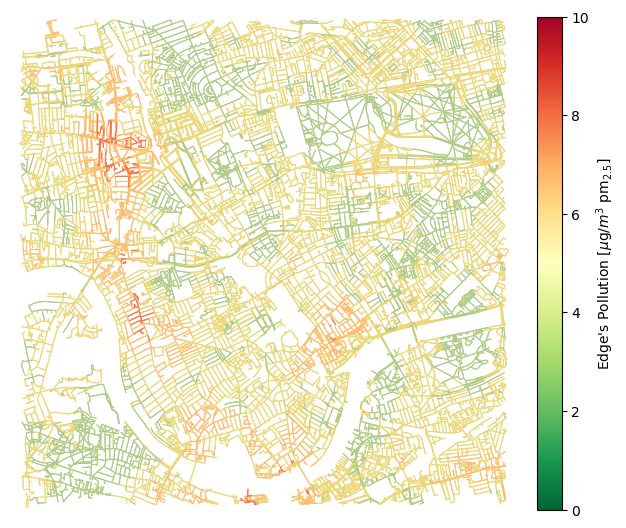

In [5]:
def assignColor (morningPredictions_, value):
    """
    Function to assign color according to pollution prediction values
    input: pd.DataFrame prediction (actually redundant)
           float -> value to assess color
    output: String color value
    """
    color1 = "#006837" #( 0 , 104 , 55 )
    color2 = "#219B51"#( 33 , 155 , 81 )
    color3 = "#72C264"#( 114 , 194 , 100 )
    color4 = "#B7E075"#( 183 , 224 , 117 )
    color5 = '#b0cc87'#"#E9F5A1"#( 233 , 245 , 161 )
    color6 = '#edd879'#"#FEEDA1"#( 254 , 237 , 161 )
    color7 = "#FDBE6F"#( 253 , 190 , 111 )
    color8 = "#F57948"#( 245 , 121 , 72 )
    color9 = "#D93529"#( 217 , 53 , 41 )
    color10 = "#A50026"#( 165 , 0 , 38 )
    colorList = [color1,color2,color3,color4,color5,
                color6,color7,color8,color9,color10]

    maxValue = 10 
    minValue = 0 
    valuesRange = (maxValue - minValue) / len(colorList);
    classIndex = int((value - minValue) / valuesRange);
    classIndex = max(0, min(classIndex, len(colorList) - 1)); # get index for colorList

    return colorList[classIndex];


edge_lengths = edges.Pollution

nc = []
for i in edge_lengths: # assign color for loop
    #print('edge',i)
    nc.append(assignColor(gridGeom,i))

# select colormap
cmap = "RdYlGn_r"
#nc = ox.plot.get_edge_colors_by_attr(G, attr="Pollution", cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
ox.plot_graph(G, edge_color=nc,node_color='none', node_alpha = 0.3,node_edgecolor = "none",
                        bgcolor='lightgray', edge_linewidth=0.75, ax = ax, edge_alpha = 1,
                       show = False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=10))
sm.set_array(edge_lengths)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.03, shrink=0.8)
cbar.set_label("Edge's Pollution [$\mu$g/$m^3$ pm$_{2.5}$]")
#fig.savefig('./data/ForVisualization/Pollution_Edges_morning.png') #Change name according to date

##  Process grid geom polygons to handle dataframe as geopandas df

In [6]:
from shapely.geometry import Polygon
# Process grid geom polygons to handle dataframe as geopandas df

polygonList = []
for i in gridGeom.geometry:
    #print(i)
    try:
        #print(type(i))
        j = i.split('_')
        #print(j)
        polygon = []
        for coordinates in j:
            coords = []
            for coord in coordinates.split():
                coords.append(float(coord))
            polygon.append(coords)
        polygonList.append(Polygon(polygon))
    except:
        print('could not process that row')
    
gridGeom["geometry"] = polygonList
gridGeom.head()
polyDataFrame = GeoDataFrame(gridGeom, crs = "EPSG:4326") # obtain polygon dataframe

# Assign color to polygons based on the predicted pollution values
Colors = []
for index, row in polyDataFrame.iterrows():
    #print(row["predicted_pm2.5"])
    color = assignColor(polyDataFrame,row["predicted_pm2.5"])
    #print(color)
    Colors.append(color)

## plot grid with color codes

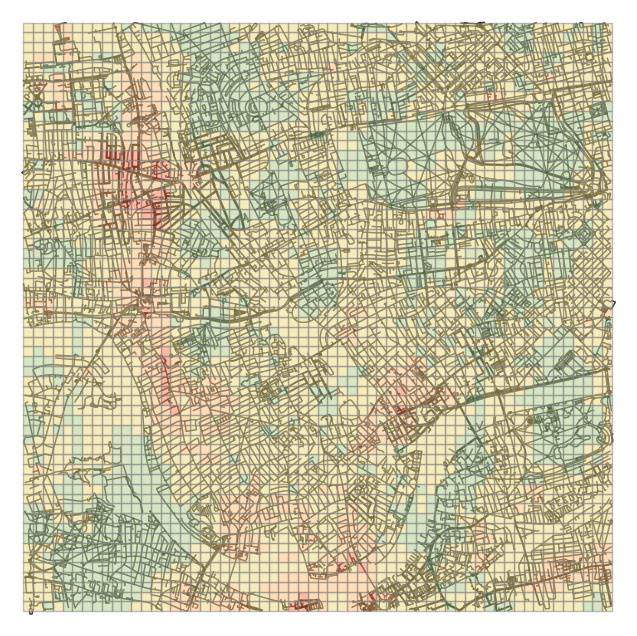

In [7]:

# plot grid with color codes

fig, ax = plt.subplots(figsize=(8,8))
#ox.plot_graph(G, edge_color='#808080', bgcolor='w', edge_alpha=0.2, node_color = "none", ax = ax, show = False)
ox.plot_graph(G, edge_color='black', bgcolor='w', edge_alpha=0.5, node_color = "none", ax = ax, show = False)

polyDataFrame.plot(facecolor = Colors, alpha = 0.5, edgecolor = 'grey', ax = ax)
limits = plt.axis()
#print(limits)
plt.show()

(-0.24769030611841636, -0.14441769388158363, 51.45878725258841, 51.52308874741159)


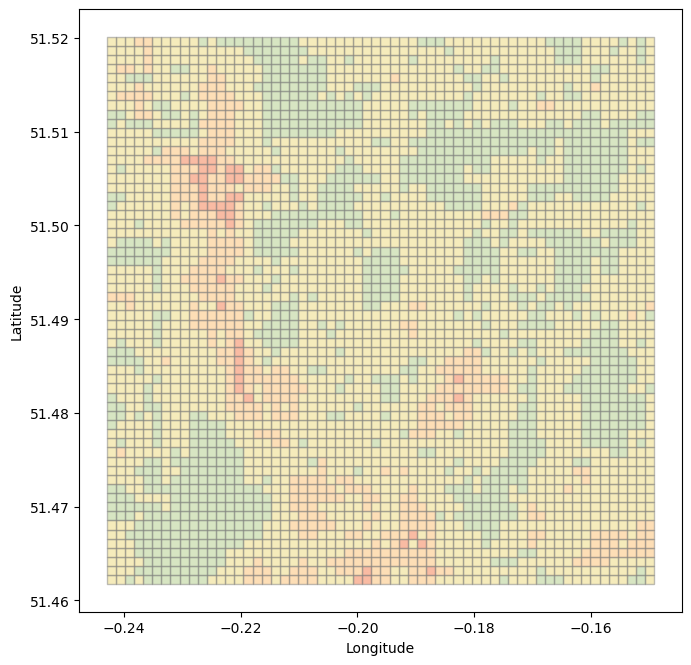

In [8]:
# print only the polygons, no map

fig, ax = plt.subplots(figsize=(7,7))
polyDataFrame.plot(facecolor = Colors, alpha = 0.5, edgecolor = 'grey', ax = ax)
limits = plt.axis()
plt.xlim([-0.24769030611841636, -0.14441769388158363]) #trying to get rid of empty space between tiles and border
plt.ylim([51.45878725258841, 51.52308874741159])
print(limits)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.tight_layout()
plt.show()